# Mutliple multiplications, multiple layers - interactive plot

I'm interested to play around with my interactive plot to see whether there is more separation between the task inputs effects in the SVD space.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 689334534
set_all_seeds(seed)
print(seed)

3482598116


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [4]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y1 = generate_Y(n_samples)
X1 = generate_X(Y1, eps)

# Ensure they are statistically independent by generating new Y and X values
Y2 = generate_Y(n_samples)
X2 = generate_X(Y2, eps)

# Stack X1 and X2 to get the desired shape
X = torch.cat((X1, X2), dim=1)

# Stack Y1 and Y2 for the desired shape
Y = torch.stack((Y1, Y2), dim=1)

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 4]) torch.Size([10000, 2])


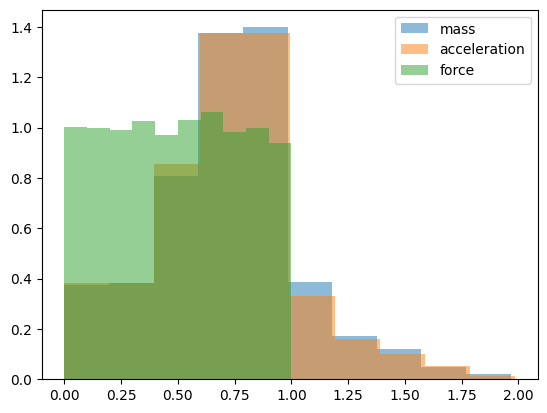

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

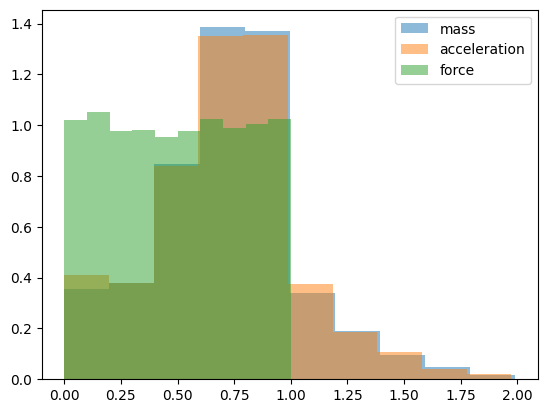

In [6]:
fig, ax = plt.subplots()

ax.hist(X[:, 2], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 3], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 1], alpha=0.5, density=True, label="force")
ax.legend()

Ok, both now look identically distributed.

In [7]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 4]),
 torch.Size([8000, 2]),
 torch.Size([2000, 4]),
 torch.Size([2000, 2]))

## Training

I'll just do full gradient descent to keep things simple.

In [8]:
N = 4000  # number of epochs
hidden_dim = 16  # number of hidden units

model = Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [9]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

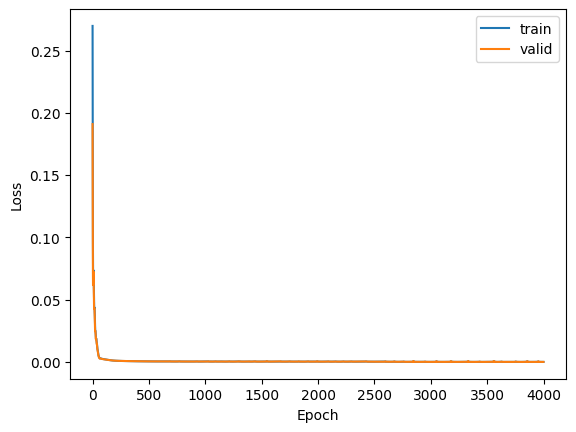

In [10]:
plot_loss(df["train_loss"], df["valid_loss"])

In [11]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 2))

In [12]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(7.6585e-05)

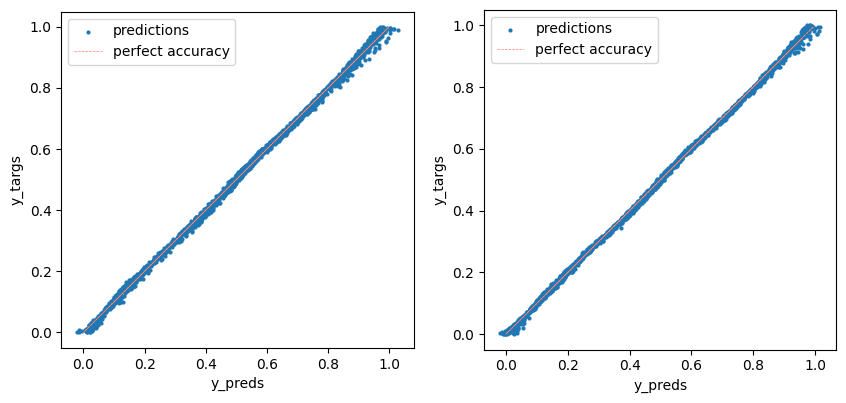

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

plot_results(y_preds[:, 0], y_targs[:, 0], ax=axes[0])
plot_results(y_preds[:, 1], y_targs[:, 1], ax=axes[1])

## Introspection

In [14]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=4, out_features=16, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=16, out_features=16, bias=True)
      (act): ReLU()
    )
    (2): LinearLayer(
      (linear): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

In [54]:
from physics_mi.analysis import capture_intermediate_outputs
import plotly.graph_objs as go
from ipywidgets import VBox, FloatSlider, HBox


U, S, V = torch.svd(model.layers[1].linear.weight)


def plot_intermediate_outputs_interactive(model, rm_keys=None):
    # Define sliders
    slider1 = FloatSlider(min=0, max=1, step=0.01, value=0.5, description="Input 1")
    slider2 = FloatSlider(min=0, max=1, step=0.01, value=0.5, description="Input 2")
    slider3 = FloatSlider(min=0, max=1, step=0.01, value=0.5, description="Input 3")
    slider4 = FloatSlider(min=0, max=1, step=0.01, value=0.5, description="Input 4")

    # Process data function that returns a dictionary
    def process_data(s1, s2, s3, s4):
        input = torch.tensor([[s1, s2, s3, s4]])
        # Replace this with your own computation
        ios = capture_intermediate_outputs(model, input)
        with torch.inference_mode():
            ios["layers.1.linear.weight.SVD"] = torch.matmul(V.T, ios["layers.0.act"].T).T
        if rm_keys is not None:
            for key in rm_keys:
                ios.pop(key)
        return ios

    # Create a dictionary of figures, one for each entry in the processed data
    figures = {}

    for chart_name, data in process_data(slider1.value, slider2.value, slider3.value, slider4.value).items():
        data = data[0].numpy()
        fig = go.FigureWidget(data=[go.Bar(x=[f"{i+1}" for i in range(len(data))], y=data)])
        fig.update_layout(title=f"{chart_name}", xaxis_title="Neurons", yaxis_title="Value", yaxis=dict(range=[-1, 1]))
        figures[chart_name] = fig

    # Function to update all the figures
    def update_graph(change):
        processed_data = process_data(slider1.value, slider2.value, slider3.value, slider4.value)
        for chart_name, data in processed_data.items():
            data = data[0].numpy()
            figures[chart_name].data[0].y = data

    # Observe changes to the slider values
    slider1.observe(update_graph, names="value")
    slider2.observe(update_graph, names="value")
    slider3.observe(update_graph, names="value")
    slider4.observe(update_graph, names="value")

    # Display sliders and the figures
    display(VBox([slider1, slider2, slider3, slider4] + [figures[name] for name in figures]))

In [58]:
rm_keys = [
    "layers.2.linear.weight",
    "layers.2.linear.bias",
    "layers.1.act",
    "layers.1.linear.weight",
    "layers.1.linear.bias",
    "layers.0.linear.weight",
    "layers.0.linear.bias",
]

In [59]:
plot_intermediate_outputs_interactive(model, rm_keys=rm_keys)

This was worth a try but I don't think has been successful. The dimensions seem just as cross-dependent on the inputs as before.

Thinking about this a little more now, the network doesn't necessarily need to produce a space that's invariant in Task B for changes in Task A inputs until it reaches the very final layer of the network (where it counts) so we might not expect to see it in the middle of the network. This is hurting my head a lot.